### Process data stored in Google sheets, to get a few consolidated dataframes

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials
import time

In [2]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

# Open the spreadsheet
SPREADSHEET_NAMES = ["sparse_majority_41_5", "sparse_majority_21_5", "sparse_parity_21_4"]
BF_VALS = [
    list(range(0, 50, 5)),
    list(range(0, 50, 5)),
    [0, 1, 2, 5, 7.5, 10, 12.5, 15, 17.5, 20],
]
NAME_TEMPLATES = [
    '{}_sparse_majority_k5_nbits41_n2000_bf{}_seed1234',
    '{}_sparse_majority_k5_nbits21_n2000_bf{}_seed1234',
    '{}_sparse_parity_k4_nbits21_n5000_bf{}_seed1234',
]



In [6]:
for i in range(len(SPREADSHEET_NAMES)):
    if i != 2: # just do sparity.
        continue
    SPREADSHEET_NAME = SPREADSHEET_NAMES[i]
    bf_vals = BF_VALS[i]
    sheetname_template = NAME_TEMPLATES[i]

    # build a hash of the spreadsheets...
    spreadsheet = client.open(SPREADSHEET_NAME)
    sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
    name_to_idx = {}
    for i, name in enumerate(sheet_names):
        name_to_idx[name] = i

    # compile everything into a big DF
    all_dfs = []
    for k in ["RNN", "SAN"]:
        for bf in bf_vals:
            target = sheetname_template.format(k, bf)
            target_idx = name_to_idx.get(target)
            print("Loading:", target)
            sheet = spreadsheet.get_worksheet(target_idx)
            data = sheet.get_all_records()
            df = pd.DataFrame(data)

            # check for additional data
            try_1 = target + "_ud"
            try_2 = target + "_u"
            if try_1 in sheet_names or try_2 in sheet_names:
                if try_1 in sheet_names:
                    to_try = try_1
                else:
                    to_try = try_2

                print("Loading additional data for:", to_try)
                sheet_ud = spreadsheet.get_worksheet(name_to_idx[to_try])
                data_ud = sheet_ud.get_all_records()
                df_ud = pd.DataFrame(data_ud)
                # concatentate the above df with the new one
                df = pd.concat([df, df_ud], ignore_index=True)

            # tag this df with the bf value and keyword k
            df["bf"] = bf
            df["model"] = k
            all_dfs.append(df)

    # concatenate all the dfs together
    all_dfs = pd.concat(all_dfs, ignore_index=True)
    # save with the associated identifier
    all_dfs.to_csv(f"./processed/{SPREADSHEET_NAME}.csv", index=False)

Loading: RNN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf1_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf2_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf5_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf7.5_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf12.5_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf15_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf17.5_seed1234
Loading: RNN_sparse_parity_k4_nbits21_n5000_bf20_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf1_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf2_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf5_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf7.5_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
Loading: SAN_sparse_parity_k4_nbits21_n5000_bf12.5_seed1234
Loading: SAN_s

### Compute maximum likelihood, entropies

In [4]:
n_data = 100000 # ~maximum~ amount of data to analyze
seed = 1234 
inc = 50000 # increment at which to check convergence
intermediate_idx = list(range(inc, n_data, inc))


def sparse_majority_k5(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    # for any sparse majority (n, 5)
    return make_datasets.sparse_majority_k_n(n_bits, 5, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

def sparity_k4(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_parity_k_n(n_bits, 4, n_data, p_bitflip, seed, subseq_idx=subseq_idx)


N_BITS = [6, 6, 5] # defined as k+1
GENERATORS = [sparse_majority_k5, sparse_majority_k5, sparity_k4]

for j in range(len(SPREADSHEET_NAMES)):

    bf_vals = BF_VALS[j]
    n_bits = N_BITS[j]
    p_bitflips = [bf / 100 for bf in bf_vals]
    generator = GENERATORS[j]
    all_H = []
    all_mle_noisy = []
    all_mle_noiseless = []
    # all_mle_train = []

    for i in range(len(p_bitflips)):
        X, Z, idx = generator(n_data, n_bits, p_bitflips[i], seed)
        # compute the mle performance and the mle lookup table for this dataset
        H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
        all_H.append(H_results[-1])
        all_mle_noisy.append(mle_results[-1])
        # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
        mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
        all_mle_noiseless.append(mle_noiseless)
        
    # save the results to a dataframe
    df = pd.DataFrame(np.array([all_H, all_mle_noisy, all_mle_noiseless, p_bitflips]).T, columns=["entropy", "mle_noisy", "mle_noiseless", "bf"])
    # save the dataframe to a csv file
    df.to_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv", index=False)

KeyboardInterrupt: 

# Batched analysis and plotting

In [ ]:
def bootstrap_fraction_in_range(x, b, delta=0.01, n_boot=5000, ci=50):
    # observed fraction of x that are at least b - delta
    frac_obs = np.mean((x >= b - delta))
    
    # run bootstrap
    boot_vals = []
    for _ in range(n_boot):
        sample = np.random.choice(x, size=len(x), replace=True)
        boot_vals.append(np.mean((sample >= b - delta)))
    boot_vals = np.array(boot_vals)
    
    # compute confidence interval
    alpha = 100 - ci
    lower = np.percentile(boot_vals, alpha/2)
    upper = np.percentile(boot_vals, 100 - alpha/2)
    # return error bars!
    return frac_obs, np.array((frac_obs - lower, upper - frac_obs)).reshape(2, -1)

In [22]:
for i, bf in enumerate(bf_vals):
    df1 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]
    x, bds = bootstrap_fraction_in_range(df2['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=50)
    print(x, bds.flatten())

0.3233333333333333 [0.02       0.01666667]
0.3333333333333333 [0.02       0.01666667]
0.33666666666666667 [0.01666667 0.01666667]
0.41333333333333333 [0.02 0.02]
0.398 [0.014 0.014]
0.194 [0.012 0.012]
0.18666666666666668 [0.01666667 0.01333333]
0.09666666666666666 [0.01333333 0.01      ]
0.0 [0. 0.]
0.0 [0. 0.]


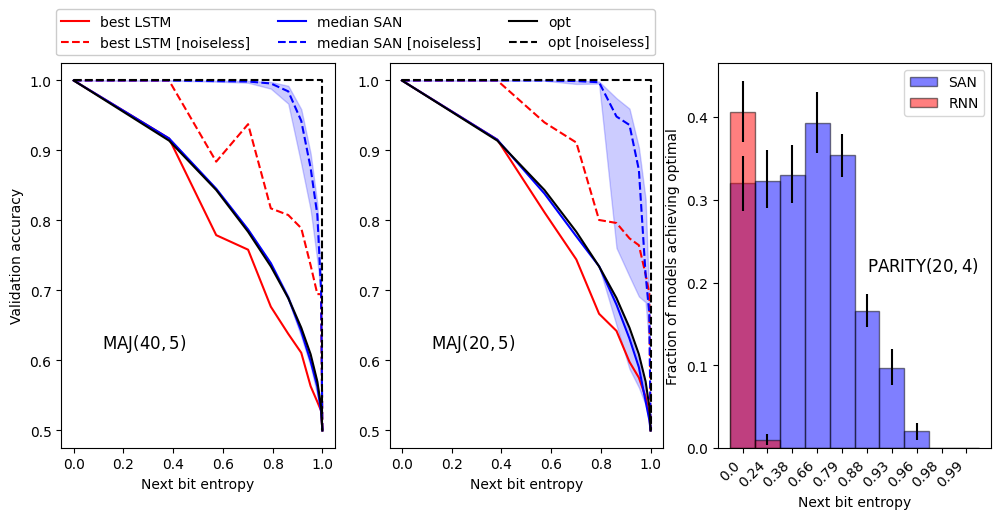

In [24]:

def append_last(x, y):
    # return (x, y)
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

DATASET_NAMES = [
    r"$\text{MAJ}(40, 5)$",
    r"$\text{MAJ}(20, 5)$",
    r"$\text{PARITY}(20, 4)$"
]
for j in range(len(SPREADSHEET_NAMES) - 1):
    ax = axes[j]
    # Read the CSV file into a DataFrame
    bf_vals = BF_VALS[j]
    df_all = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
    df_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")

    rnn_stats = np.zeros((len(bf_vals), 8)) # val_acc median, q1, q3, max_val_acc, noiseless_val_acc median, q1, q3, max_noiseless_val_acc
    san_stats = np.zeros((len(bf_vals), 8))

    stats_dct = {
        "RNN": rnn_stats,
        "SAN": san_stats
    }

    for k in stats_dct.keys():
        for i, bf in enumerate(bf_vals):
            df = df_all.loc[df_all["bf"] == bf].loc[df_all["model"] == k]
            stats_dct[k][i, 0] = df['val_acc'].median()
            stats_dct[k][i, 1] = df['val_acc'].quantile(0.35)
            stats_dct[k][i, 2] = df['val_acc'].quantile(0.85)
            stats_dct[k][i, 3] = df['val_acc'].max()
            stats_dct[k][i, 4] = df['noiseless_val_acc'].median()
            stats_dct[k][i, 5] = df['noiseless_val_acc'].quantile(0.33)
            stats_dct[k][i, 6] = df['noiseless_val_acc'].quantile(0.67)
            stats_dct[k][i, 7] = df['noiseless_val_acc'].max()


    
    xvals = df_ana["entropy"].values.flatten() # entropy x-axis
    # xvals = df_ana["bf"].values.flatten() # bitflip x-axis
    mle_noisy_final = df_ana["mle_noisy"].values.flatten()

    rnn_noisy = np.array(stats_dct["RNN"][:,3]).flatten()
    rnn_noiseless = np.array(stats_dct["RNN"][:,7]).flatten()
    san_noisy = np.array(stats_dct["SAN"][:,0]).flatten()
    san_noiseless = np.array(stats_dct["SAN"][:,4]).flatten()
    san_q1 = np.array(stats_dct["SAN"][:,1]).flatten()
    san_q3 = np.array(stats_dct["SAN"][:,2]).flatten()
    san_q1_noiseless = np.array(stats_dct["SAN"][:,5]).flatten()
    san_q3_noiseless = np.array(stats_dct["SAN"][:,6]).flatten()

    ax.plot(*append_last(xvals, rnn_noisy), label='best LSTM', c='r', ls='-')
    ax.plot(*append_last(xvals, rnn_noiseless), label='best LSTM [noiseless]', c='r', ls='--')

    ax.plot(*append_last(xvals, san_noisy), label='median SAN', c='b', ls='-')
    ax.plot(*append_last(xvals, san_noiseless), label='median SAN [noiseless]', c='b', ls='--')
    ax.fill_between(xvals, san_q1, san_q3, color='b', alpha=0.2)
    ax.fill_between(xvals, san_q1_noiseless, san_q3_noiseless, color='b', alpha=0.2)

    ax.plot(*append_last(xvals, mle_noisy_final), label='opt', c='k', ls='-')
    ax.plot([0, 1, 1], [1, 1, 0.5], label='opt [noiseless]', c='k', ls='--')
    ax.set_xlabel('Next bit entropy')
    ax.text(0.15, 0.3, DATASET_NAMES[j], ha='left', va='top', fontsize=12, transform=ax.transAxes)

axes[0].set_ylabel('Validation accuracy')
axes[0].legend(prop={'size': 10}, framealpha=1, ncol=3, loc='lower left', bbox_to_anchor=(-0.02, 1.02), borderaxespad=0.)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# third axis: do sparse parity
j = 2
bf_vals = BF_VALS[j]
df_sparity = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_sparity_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
entropies = df_sparity_ana["entropy"].values.flatten()
for i, bf in enumerate(bf_vals):
    df1 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]
    # entropies.append(entropy[0])
    # entropy = bf / 100
    mle_noiseless = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noiseless"].values.flatten()
    mle_noisy = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noisy"].values.flatten()

    epsilon = 0.01
    # compute fractions of models that achieved MLE performance
    ci = 80

    san_val_frac, san_val_bounds = bootstrap_fraction_in_range(df2['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # san_noiseless_val_frac, san_noiseless_bounds = bootstrap_fraction_in_range(df2['noiseless_val_acc'].values, mle_noisy)
    rnn_val_frac, rnn_val_bounds = bootstrap_fraction_in_range(df1['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # rnn_noiseless_val_frac, rnn_noiseless_val_bounds = bootstrap_fraction_in_range(df1['noiseless_val_acc'].values, mle_noiseless)
    
    width = 1
    axes[2].bar(i, san_val_frac, width=width, color='b', alpha=0.5, label=('SAN' if i == 0 else None), align='center', edgecolor='k', yerr=san_val_bounds)
    axes[2].bar(i, rnn_val_frac, width=width, color='r', alpha=0.5, label=('RNN' if i == 0 else None), align='center', edgecolor='k', yerr=rnn_val_bounds)
    # axes[1].bar(i, san_noiseless_val_frac, width=width, color='b', alpha=0.5, label='SAN [noiseless]', align='center', edgecolor='k')
    # axes[1].bar(i, rnn_noiseless_val_frac, width=width, color='r', alpha=0.5, label='RNN [noiseless]', align='center', edgecolor='k')


entropy_rounded = np.round(entropies, 2)
axes[2].set_xticks(range(len(bf_vals)), entropy_rounded, rotation=45, ha='right')
axes[2].set_xlabel('Next bit entropy')
axes[2].set_ylabel('Fraction of models achieving optimal')
axes[2].legend()
axes[2].text(0.75, 0.5, DATASET_NAMES[j], ha='center', va='top', fontsize=12, transform=axes[2].transAxes)

# save the figure
plt.savefig(f"./figures/fig1.pdf", dpi=300, bbox_inches='tight')
            

#### Appendix material:
 - The same far-right bar plot but for the first two plots provided here.
 - commentary on sparity(20, 4), e.g. bimodal distibution is a shitter to visualize.

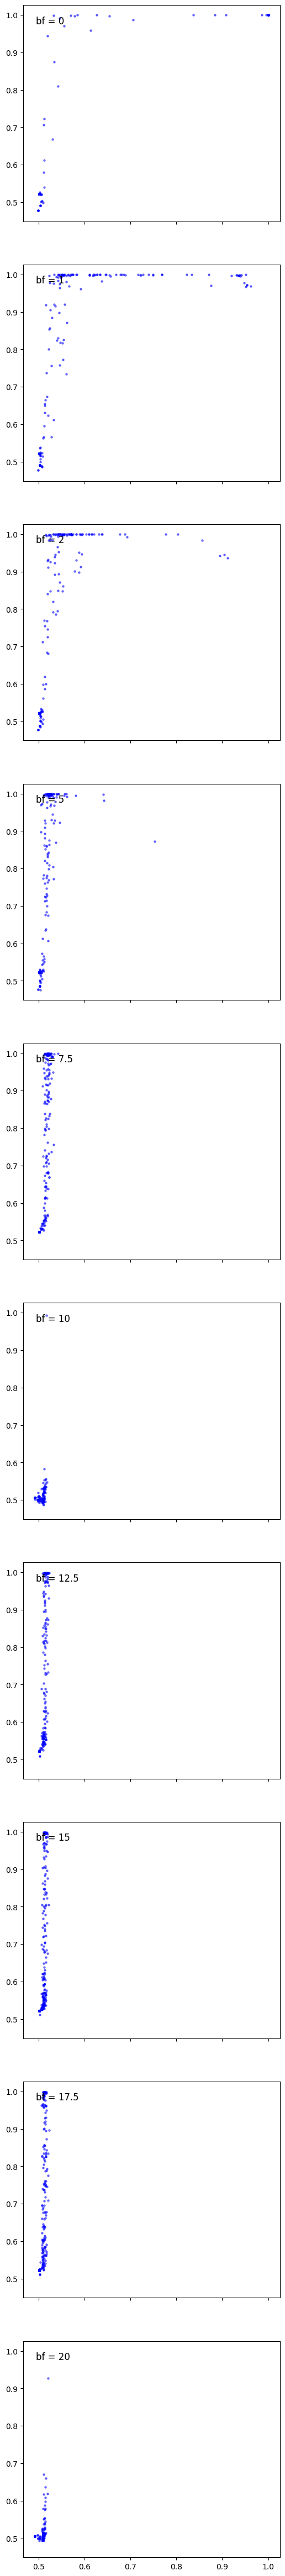

In [40]:
j = 2
bf_vals = BF_VALS[j]
df_sparity = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_sparity_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
entropies = df_sparity_ana["entropy"].values.flatten()
fig, axes = plt.subplots(len(bf_vals), 1, figsize=(6, 6*len(bf_vals)), sharex=True, sharey=True)
for i, bf in enumerate(bf_vals):
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    # df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]
    axes[i].scatter(df2['val_acc'], df2['train_acc'], alpha=0.5, s=5, c='b', label='SAN')
    axes[i].text(0.05, 0.95, f"bf = {bf}", ha='left', va='top', fontsize=12, transform=axes[i].transAxes)



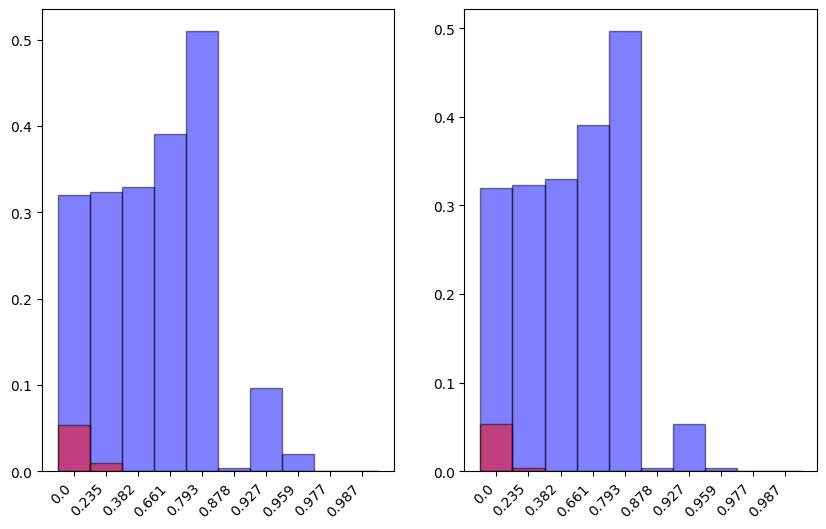

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
entropies = df_sparity_ana["entropy"].values.flatten()
# make widths that are diffs of each consecutive entropy value
diffs = np.diff(entropies)
# add a final width of 1 - last entropy value
widths = np.concatenate([diffs, [1 - entropies[-1]]])
# fig, axes = plt.subplots(len(bf_vals), 2, figsize=(6, 12), sharex=True, sharey=True, constrained_layout=True)
for i, bf in enumerate(bf_vals):
    df1 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]
    # entropies.append(entropy[0])
    # entropy = bf / 100
    mle_noiseless = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noiseless"].values.flatten()
    mle_noisy = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noisy"].values.flatten()

    epsilon = 0.01
    # compute fractions of models that achieved MLE performance
    san_val_acc = df2['val_acc'].values
    san_val_frac = np.sum(np.abs(san_val_acc - mle_noisy) < epsilon) / len(san_val_acc)
    san_noiseless_val_acc = df2['noiseless_val_acc'].values
    san_noiseless_val_frac = np.sum(np.abs(san_noiseless_val_acc - mle_noiseless) < epsilon) / len(san_noiseless_val_acc)
    rnn_val_acc = df1['val_acc'].values
    rnn_val_frac = np.sum(np.abs(rnn_val_acc - mle_noisy) < epsilon) / len(rnn_val_acc)
    rnn_noiseless_val_acc = df1['noiseless_val_acc'].values
    rnn_noiseless_val_frac = np.sum(np.abs(rnn_noiseless_val_acc - mle_noiseless) < epsilon) / len(rnn_noiseless_val_acc)
    
    width = 1
    axes[0].bar(i, san_val_frac, width=width, color='b', alpha=0.5, label='SAN', align='center', edgecolor='k')
    axes[0].bar(i, rnn_val_frac, width=width, color='r', alpha=0.5, label='RNN', align='center', edgecolor='k')
    axes[1].bar(i, san_noiseless_val_frac, width=width, color='b', alpha=0.5, label='SAN [noiseless]', align='center', edgecolor='k')
    axes[1].bar(i, rnn_noiseless_val_frac, width=width, color='r', alpha=0.5, label='RNN [noiseless]', align='center', edgecolor='k')


entropy_rounded = np.round(entropies, 3)
for ax in axes:
    ax.set_xticks(range(len(bf_vals)), entropy_rounded, rotation=45, ha='right')


# all_y_rnn = np.concatenate(all_y_rnn)
# all_y_san = np.concatenate(all_y_san)
# all_x_rnn = np.concatenate(all_x_rnn)
# all_x_san = np.concatenate(all_x_san)

# # print(len(all_y), len(all_x_rnn), len(all_x_san))
# # fig, axes = plt.subplots(5, 2, figsize=(12, 20), sharey=True)
# fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
# bf_bins = np.array([bf/100 for bf in bf_vals])
# axes[0].hist2d(all_x_rnn, all_y_rnn, bins=(10, len(bf_vals) + 1), cmap='Blues', cmin=1, density=True)
# axes[1].hist2d(all_x_san, all_y_san, bins=(10, len(bf_vals)+ 1), cmap='Reds', cmin=1, density=True)

# print()

In [ ]:

name = "sparse_majority_21_5"
sheetname1 = "RNN_sparse_majority_k5_nbits21_n2000_bf10_seed1234"
sheetname2 = "RNN_sparse_majority_k5_nbits21_n2000_bf10.0_seed1234_results"
# load these two things
spreadsheet = client.open(name)
sheet1 = spreadsheet.worksheet(sheetname1)
sheet2 = spreadsheet.worksheet(sheetname2)
data1 = sheet1.get_all_records()
data2 = sheet2.get_all_records()
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [25]:

name = "sparse_parity_21_4"
sheetname1 = "RNN_sparse_parity_k4_nbits21_n5000_bf0_seed1234"
# sheetname2 = "RNN_sparse_parity_k5_nbits21_n2000_bf10.0_seed1234_results"
# load these two things
spreadsheet = client.open(name)
sheet1 = spreadsheet.worksheet(sheetname1)
data1 = sheet1.get_all_records()
df1 = pd.DataFrame(data1)


c:\Users\peter\Desktop\projects\MindReadingAutobot\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


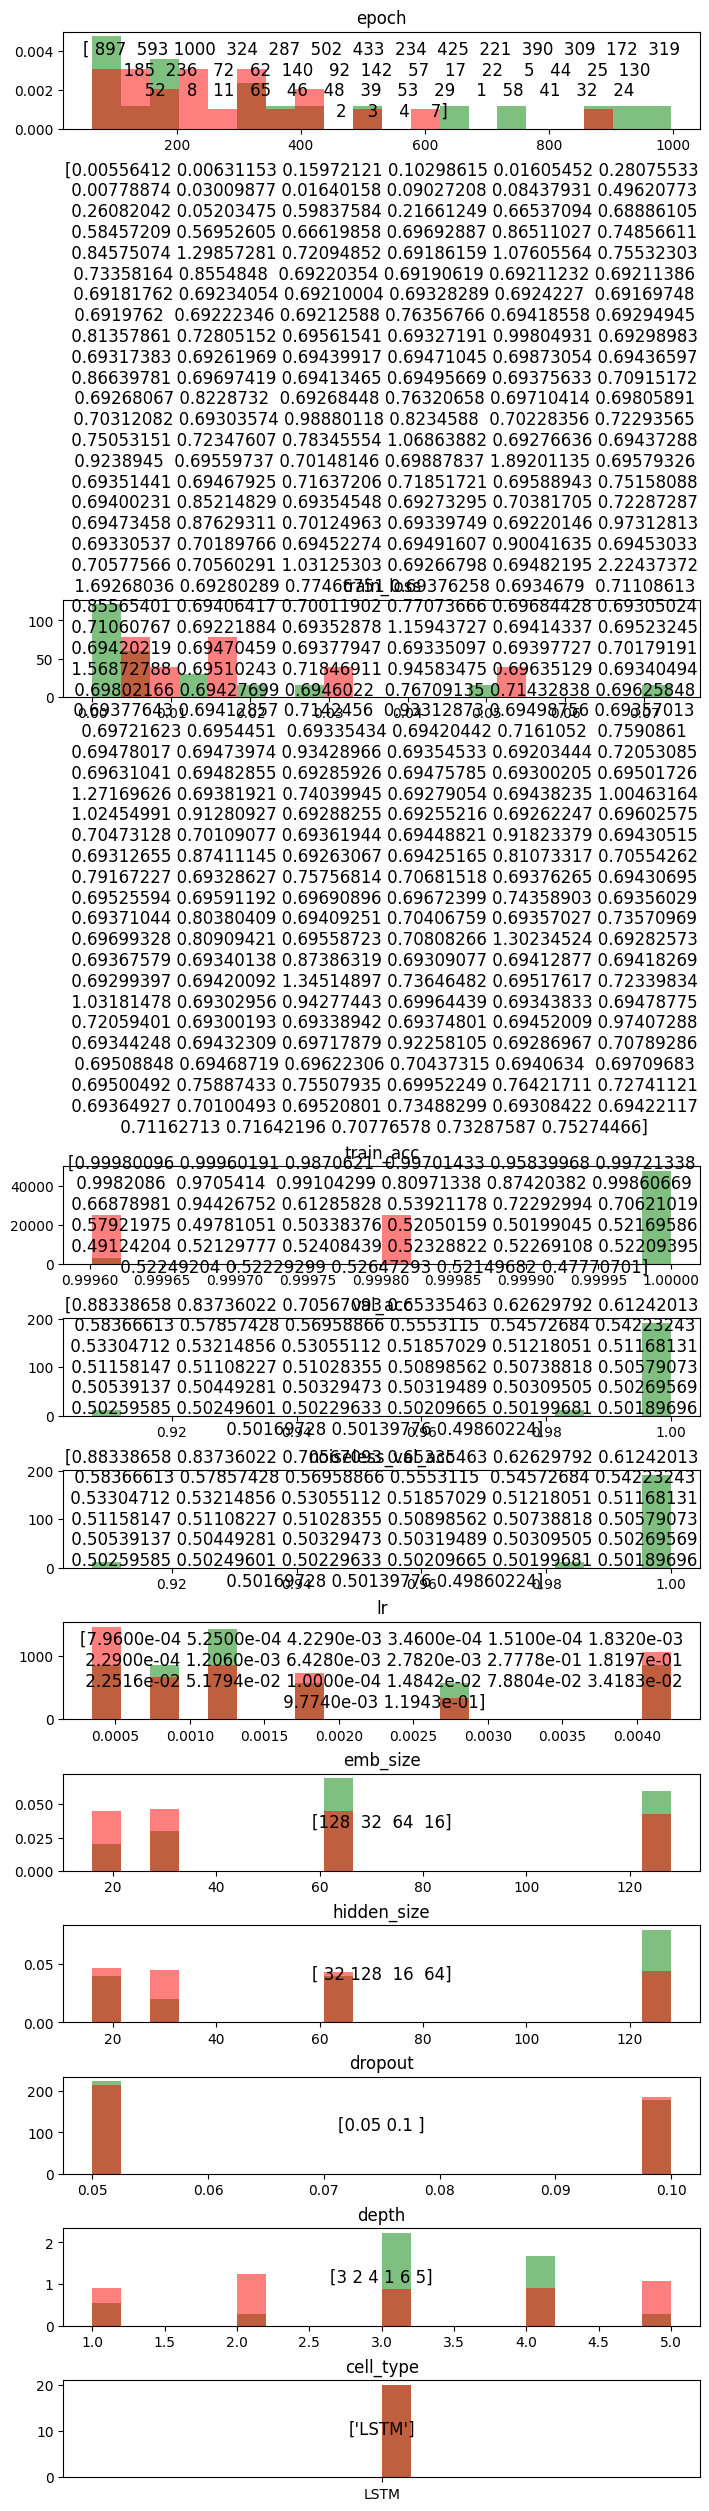

In [31]:
good = df1[df1["noiseless_val_acc"] > 0.9]
bad = df1[df1["noiseless_val_acc"] < 0.9]

n_columns = len(df1.columns)
fig, axes = plt.subplots(n_columns, 1, figsize=(7, 25), constrained_layout=True)
for col in range(n_columns):
    # get the column name
    col_name = df1.columns[col]
    # plot the good and bad data
    cts, bins, _ = axes[col].hist(good[col_name], bins=20, alpha=0.5, label='good', color='g', density=True)
    axes[col].hist(bad[col_name], bins=bins, alpha=0.5, label='bad', color='r', density=True)
    axes[col].set_title(col_name)
    axes[col].text(0.5, 0.5, bad[col_name].unique(), ha='center', va='center', fontsize=12, transform=axes[col].transAxes)
    # axes[col].legend()

In [ ]:
array([3.000e-04, 5.000e-04, 8.000e-04, 1.200e-03, 1.800e-03, 2.800e-03, 4.200e-03, 6.400e-03, 9.800e-03])

In [37]:
display(np.round(np.array(list(sorted(bad["lr"].unique()))), 4))

array([1.000e-04, 2.000e-04, 2.000e-04, 3.000e-04, 5.000e-04, 8.000e-04,
       1.200e-03, 1.800e-03, 2.800e-03, 4.200e-03, 6.400e-03, 9.800e-03,
       1.480e-02, 2.250e-02, 3.420e-02, 5.180e-02, 7.880e-02, 1.194e-01,
       1.820e-01, 2.778e-01])

[]

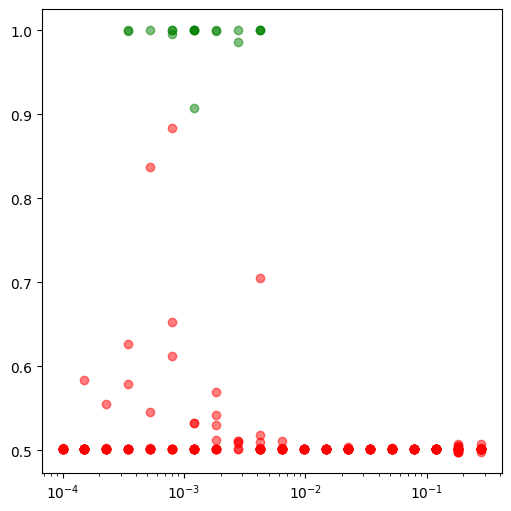

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

ax.scatter(good["lr"], good["val_acc"], c='g', alpha=0.5, label='good')
ax.scatter(bad["lr"], bad["val_acc"], c='r', alpha=0.5, label='bad')
ax.semilogx()
